In [167]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pystan
import arviz as az

sns.set(style='whitegrid')

In [13]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""
  
    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    # Plotting
    ax1.plot(param)
    ax1.set(xlabel='samples', ylabel=param_name,
           title='Trace and Posterior Distribution for {}'.format(param_name)
           )
    ax1.axhline(mean, color='r', lw=2, linestyle='--')
    ax1.axhline(median, color='c', lw=2, linestyle='--')
    ax1.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
    ax1.axhline(cred_max, linestyle=':', color='k', alpha=0.2)

    ax2.hist(param, 30, density=True)
    sns.kdeplot(param, shade=True, ax=ax2)
    ax2.set(xlabel=param_name, ylabel='density')
    ax2.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
    ax2.axvline(median, color='c', lw=2, linestyle='--',label='median')
    ax2.axvline(cred_min, linestyle=':', color='k', alpha=0.3, label='95% CI')
    ax2.axvline(cred_max, linestyle=':', color='k', alpha=0.3)

    fig.tight_layout()
    plt.legend()


In [6]:
df = (pd.read_excel('~/Dropbox/ROZ/data/Fontainebleau/Goudarzi et al. 2018.xlsx')
     .assign(Class=lambda x: x.Class.fillna(method='ffill'))
     )
df.head()

,Class,Sample,L (mm),Dm (mm),phi,k (mD),tau_h,tau_e,F,tau_e/phi,phi_c,phi-phi_c,d_min,d_max,Dp,t=D/(3-D),m,t=2m
0,A1,1,2.6571,0.176,0.1410,706.0,1.4747,1.2897,21.3457,9.146809,0.01410,0.12690,12.252799,2527.638328,2.971481,104.192724,1.562459,3.124918
1,A1,2,2.6571,0.181,0.1546,933.0,1.4716,1.2766,18.4589,8.257439,0.01546,0.13914,12.252799,2527.638328,2.968486,94.196771,1.561693,3.123386
2,A1,3,2.6571,0.180,0.1642,1126.3,1.4695,1.2681,16.7000,7.722899,0.01642,0.14778,12.252799,2527.638328,2.966343,88.135429,1.558341,3.116683
3,A1,4,2.6571,0.182,0.1795,1504.1,1.4593,1.2529,14.3050,6.979944,0.01795,0.16155,12.252799,2527.638328,2.962877,79.811506,1.549045,3.098090
4,A1,5,2.6571,0.187,0.2037,2356.0,1.4291,1.2270,11.2323,6.023564,0.02037,0.18333,12.252799,2527.638328,2.957259,69.190137,1.520195,3.040391


The equation we are working on today is for Formation Factor and the Percolation theory version is
$$F = C_F(\phi - \phi_{te})^{-\mu}$$

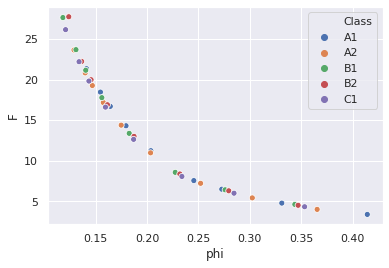

In [118]:
sns.scatterplot('phi', 'F', hue='Class', data=df)

In [9]:
df.phi.min()

0.1181

Everything looks fairly homoskedastic, so let's try a normal error term 

In [200]:
model_code = """
data {
    int<lower=1> N;
    vector[N] phi;
    vector[N] F;
}
parameters {
    real <lower=0, upper=0.118> phi_te; // Everything goes to hell if phi_te is greater than any value of phi
    real <lower=0, upper=100> C_F;
    real <lower=0> mu;
    real <lower=0> sigma_e;
}
transformed parameters {
    real mean_F[N];
    for (i in 1:N)
        mean_F[i] = C_F * (phi[i] - phi_te) ^ (-mu);
}
model {
    /*for (i in 1:N)
        F[i] ~ normal(C_F * (phi[i] - phi_te) ^ (-mu), sigma_e);*/
    F ~ normal(mean_F, sigma_e);
}
/*generated quantities {
    vector[N] log_lik;
    vector[N] F_hat;
    for (i in 1:N) {
        log_lik[i] = normal_lpdf(F[i] | mean_F[i], sigma_e);
        F_hat[i] = normal_rng(mean_F[i], sigma_e);
    }
}*/
"""
model = pystan.StanModel(model_code=model_code, model_name="Composite_formation_factor")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Composite_formation_factor_041fd32e45e218cf2021c466bc30c9fd NOW.


In [201]:
data = {'N': len(df.phi), 'phi':df.phi, 'F':df.F}
fit = model.sampling(
    data=data, iter=6000, chains=4, warmup=1000, thin=1, seed=42,
)
fit

Inference for Stan model: Composite_formation_factor_041fd32e45e218cf2021c466bc30c9fd.
4 chains, each with iter=6000; warmup=1000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi_te     5.7e-3  9.7e-5 4.8e-3 1.8e-4 1.9e-3 4.4e-3 8.2e-3   0.02   2469    1.0
C_F          0.74  8.6e-4   0.04   0.66    0.7   0.73   0.76   0.84   2683    1.0
mu           1.67  1.1e-3   0.05   1.54   1.64   1.68   1.71   1.75   2339    1.0
sigma_e       0.5  7.5e-4   0.06    0.4   0.46    0.5   0.54   0.64   6395    1.0
mean_F[1]   20.78  8.0e-4   0.11  20.57  20.71  20.78  20.85  20.99  17418    1.0
mean_F[2]   17.71  7.9e-4   0.09  17.52  17.65  17.71  17.77  17.89  13990    1.0
mean_F[3]   15.95  8.1e-4   0.09  15.76  15.89  15.95  16.01  16.13  13139    1.0
mean_F[4]   13.67  8.8e-4    0.1  13.48  13.61  13.68  13.74  13.86  11905    1.0
mean_F[5]    11.0  1.1e-3    0.1   10.8  10.93   11.0  1

<Figure size 432x288 with 0 Axes>

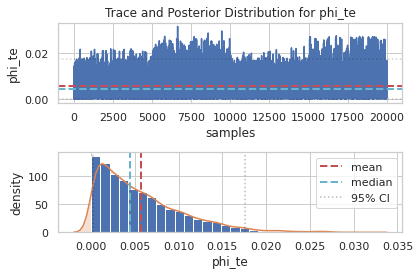

In [202]:
plt.figure()
plot_trace(fit['phi_te'], 'phi_te')

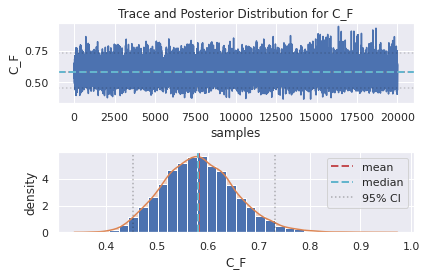

In [74]:
plot_trace(fit['C_F'], 'C_F')

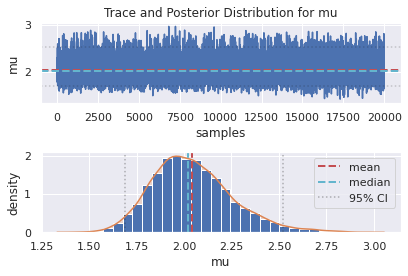

In [75]:
plot_trace(fit['mu'], 'mu')

In [55]:
def posterior_examples(phi_predict, fit, num_examples=100):
    mu = fit['mu']
    phi_te = fit['phi_te']
    C_F = fit['C_F']
    samples = np.random.choice(len(mu), num_examples)
    for e in samples:
        yield C_F[e] * (phi_predict - phi_te[e]) ** -mu[e]


[Text(0, 0.5, 'Formation factor'), Text(0.5, 0, 'Porosity')]

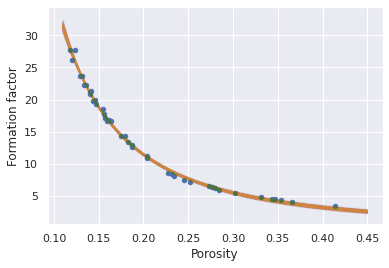

In [76]:
phi_pred = np.linspace(0.11, 0.45)
for y in posterior_examples(phi_pred, fit, 1000):
    plt.plot(phi_pred, y, color='peru', alpha=.005)
ax = plt.gca()
sc = df.plot.scatter('phi', 'F', ax=ax)
#porosity_pred = np.linspace(2.5, 35)
#k_pred = 0.51 * (porosity_pred - 2.366) ** 2.91
#plt.plot(porosity_pred, k_pred, label='Curve fit', color='crimson')
ax.set(
    xlabel='Porosity',
    #xscale='log',
    ylabel='Formation factor',
    #yscale='log', 
    #ylim=(1e-2, 2e4)
)
#plt.legend()
#plt.xticks([3,5,10,20,30],[3,5,10,20,30]);

It's interesting how well things match for the different classes, but I'm not sure what a negative $\phi_{te}$ means

In [91]:
stan_az = az.from_pystan(fit, posterior_predictive='F_hat', log_likelihood='log_lik', observed_data='F')

/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backends/matplotlib/distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
/home/frank/anaconda3/envs/bayes/lib/python3.8/site-packages/arviz/plots/backend

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50d421ce20>,
      dtype=object)

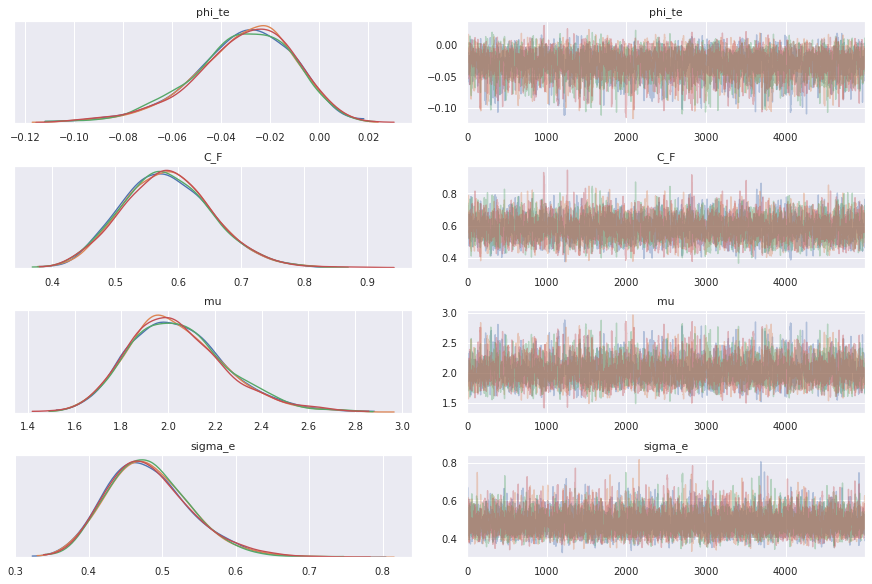

In [92]:
az.plot_trace(stan_az)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50d445b400>,
      dtype=object)

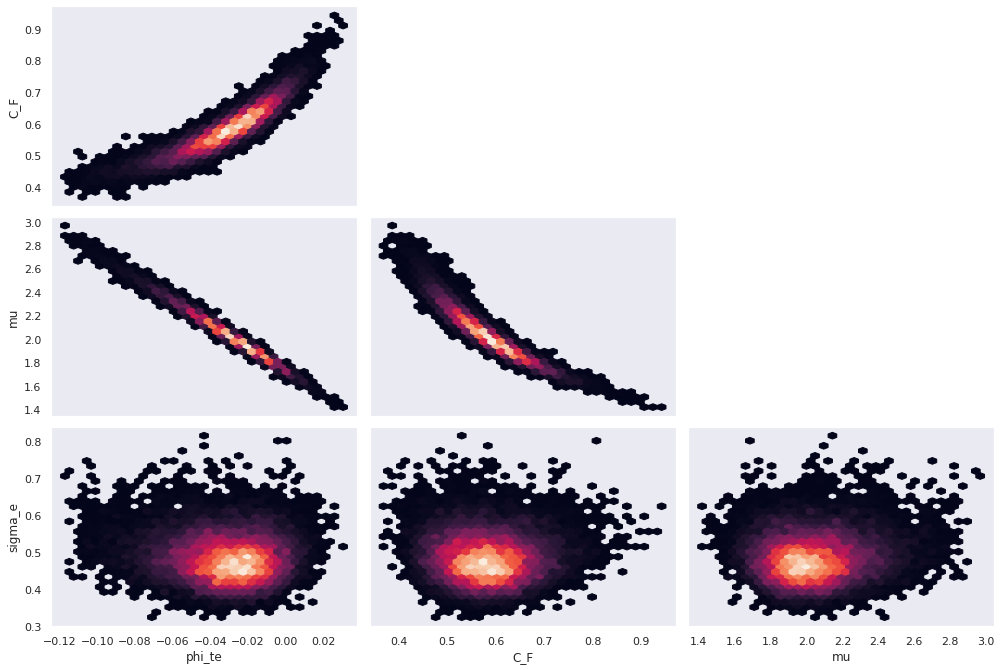

In [89]:
az.plot_pair(stan_az, kind="hexbin")

In [60]:
#az.plot_autocorr(fit)

In [99]:
stan_az = az.from_pystan(fit, posterior_predictive='F_hat', log_likelihood={"F":'log_lik'}, observed_data=['F'])

az.plot_ppc(stan_az)

KeyError: 'F'

# Heirarchical model from the classes

In [172]:
model_code_classy_mu_phi = """
data {
    int<lower=1> N;
    int<lower=1,upper=5> rock_class[N];
    vector[N] phi;
    vector[N] F;
}
parameters {
    real <lower=0, upper=0.118> phi_te[5]; // Everything goes to hell if phi_te is greater than any value of phi
    real <lower=0, upper=100> C_F[5];
    real <lower=0> mu[5];
    real <lower=0> sigma_e;
}
transformed parameters {
    real mean_F[N];
    for (i in 1:N)
        mean_F[i] = C_F[rock_class[i]] * (phi[i] - phi_te[rock_class[i]]) ^ (-mu[rock_class[i]]);
}
model {
    F ~ normal(mean_F, sigma_e);
}
"""
model_classy_mu_phi = pystan.StanModel(model_code=model_code_classy_mu_phi)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4e1a8d503c4dd81f1f2ff5d8920f8c37 NOW.


In [173]:
data = {'N': len(df.phi), 'phi':df.phi, 'F':df.F, 'rock_class':df.Class.astype('category').cat.codes + 1}
fit_classy_mu_phi = model_classy_mu_phi.sampling(
    data=data, iter=6000, chains=4, warmup=1000, thin=1, seed=42, pars=['phi_te', 'C_F', 'mu', 'sigma_e']
)
fit_classy_mu_phi

Inference for Stan model: anon_model_4e1a8d503c4dd81f1f2ff5d8920f8c37.
4 chains, each with iter=6000; warmup=1000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi_te[1]   0.02  1.2e-4   0.01 6.9e-4 6.1e-3   0.01   0.02   0.04   9416    1.0
phi_te[2]   0.01  9.8e-5 9.0e-3 4.1e-4 3.9e-3 8.7e-3   0.02   0.03   8496    1.0
phi_te[3] 8.1e-3  7.8e-5 6.9e-3 2.5e-4 2.7e-3 6.2e-3   0.01   0.03   7821    1.0
phi_te[4]   0.03  1.6e-4   0.01 3.3e-3   0.02   0.03   0.04   0.06   7676    1.0
phi_te[5]   0.01  9.5e-5 8.4e-3 3.6e-4 3.7e-3 8.2e-3   0.01   0.03   7871    1.0
C_F[1]      0.73  8.2e-4   0.08   0.59   0.67   0.72   0.77   0.92  10453    1.0
C_F[2]      0.77  8.3e-4   0.08   0.64   0.71   0.76   0.81   0.95   9191    1.0
C_F[3]      0.78  7.6e-4   0.07   0.66   0.73   0.77   0.82   0.95   9092    1.0
C_F[4]       0.8  1.4e-3   0.13   0.59   0.71   0.79   0.88    1.1   8750    1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50ca633460>,
      dtype=object)

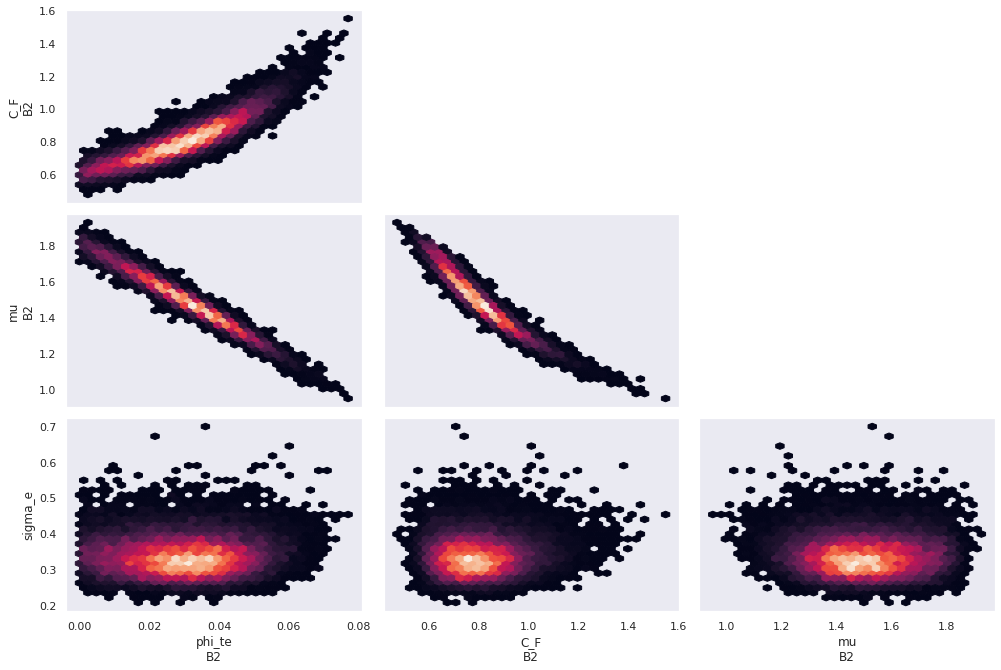

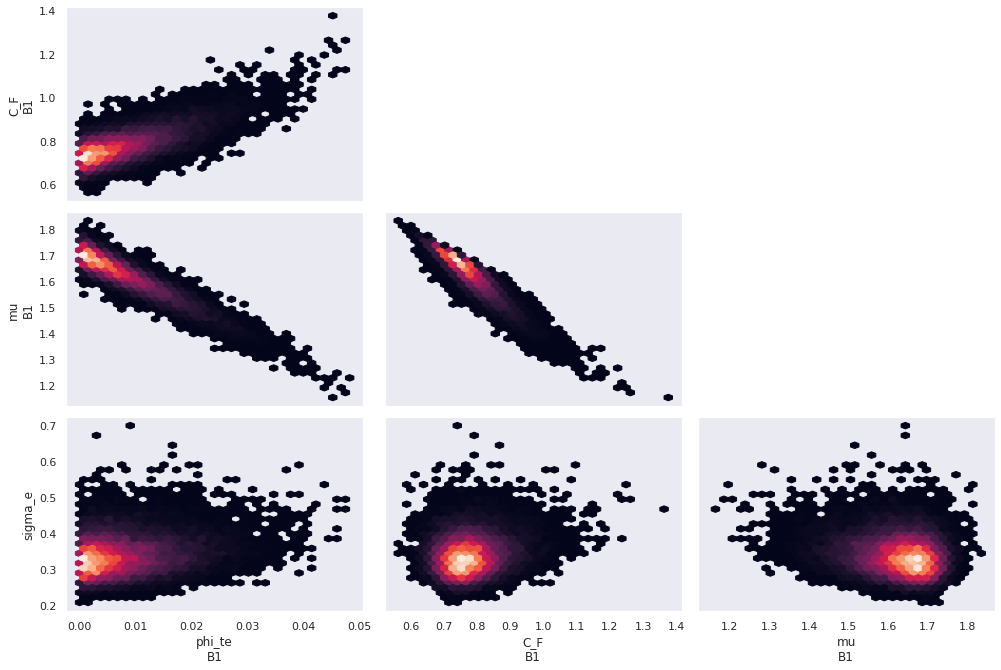

In [163]:
fit_classy_mu_phi_az = az.from_pystan(
    fit_classy_mu_phi, 
    observed_data=["F"], 
    coords={"Class": df.Class.unique()}, 
    dims = {"phi_te": ["Class"], "C_F":["Class"], "mu":["Class"]}
)
az.plot_pair(
    fit_classy_mu_phi_az,
    coords={"Class":["B2"]},
    kind="hexbin",
)

az.plot_pair(
    fit_classy_mu_phi_az,
    coords={"Class":["B1"]},
    kind="hexbin",
)

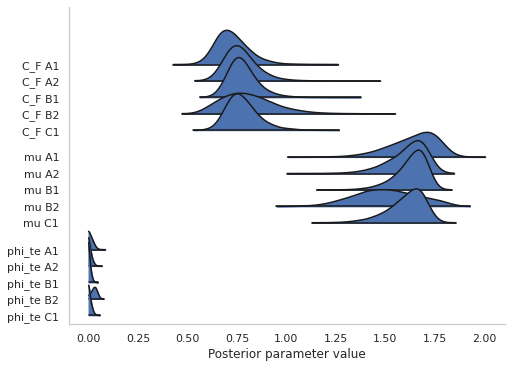

In [205]:
az.plot_forest(fit_classy_mu_phi_az, 
               var_names=['C_F', 'mu', 'phi_te'], 
               combined=True, 
               kind="ridgeplot", figsize=(7,5))
plt.xlabel('Posterior parameter value')
sns.despine()
plt.savefig('bayes_figures/formation_factor_posterior_distributions.png', bbox_inches='tight', dpi=300)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f50c2232be0>],
      dtype=object)

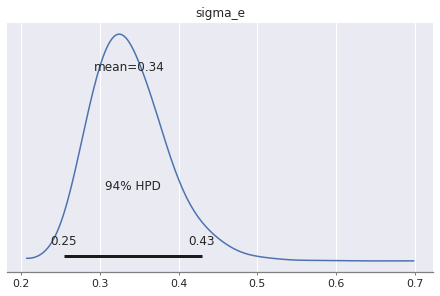

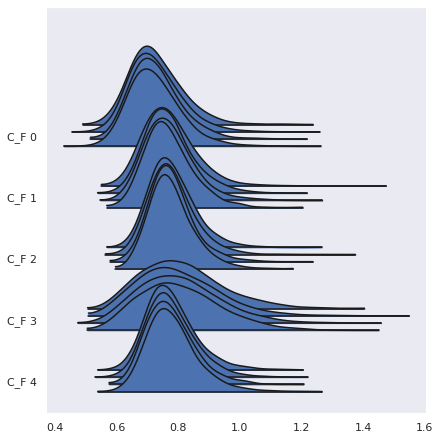

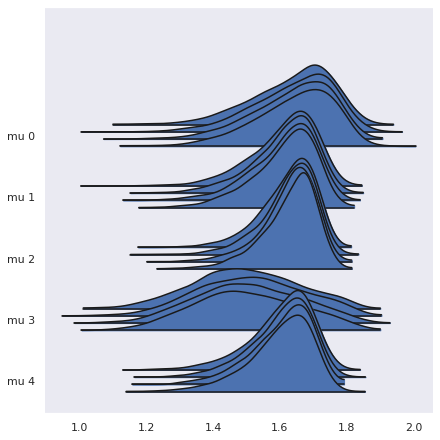

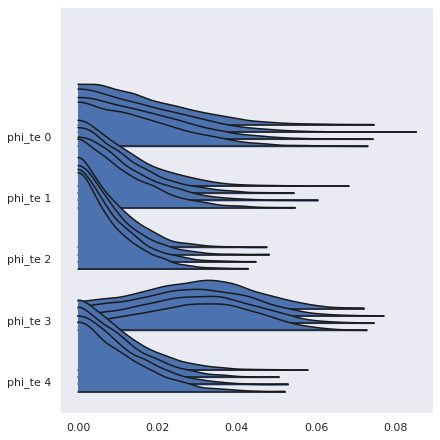

In [165]:
az.plot_posterior(fit_classy_mu_phi, var_names=['sigma_e']) #figsize=(10,10))
az.plot_forest(fit_classy_mu_phi, var_names=['C_F'], kind='ridgeplot')
az.plot_forest(fit_classy_mu_phi, var_names=['mu'], kind='ridgeplot')
az.plot_forest(fit_classy_mu_phi, var_names=['phi_te'], kind='ridgeplot')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f50f45cea90>,
      dtype=object)

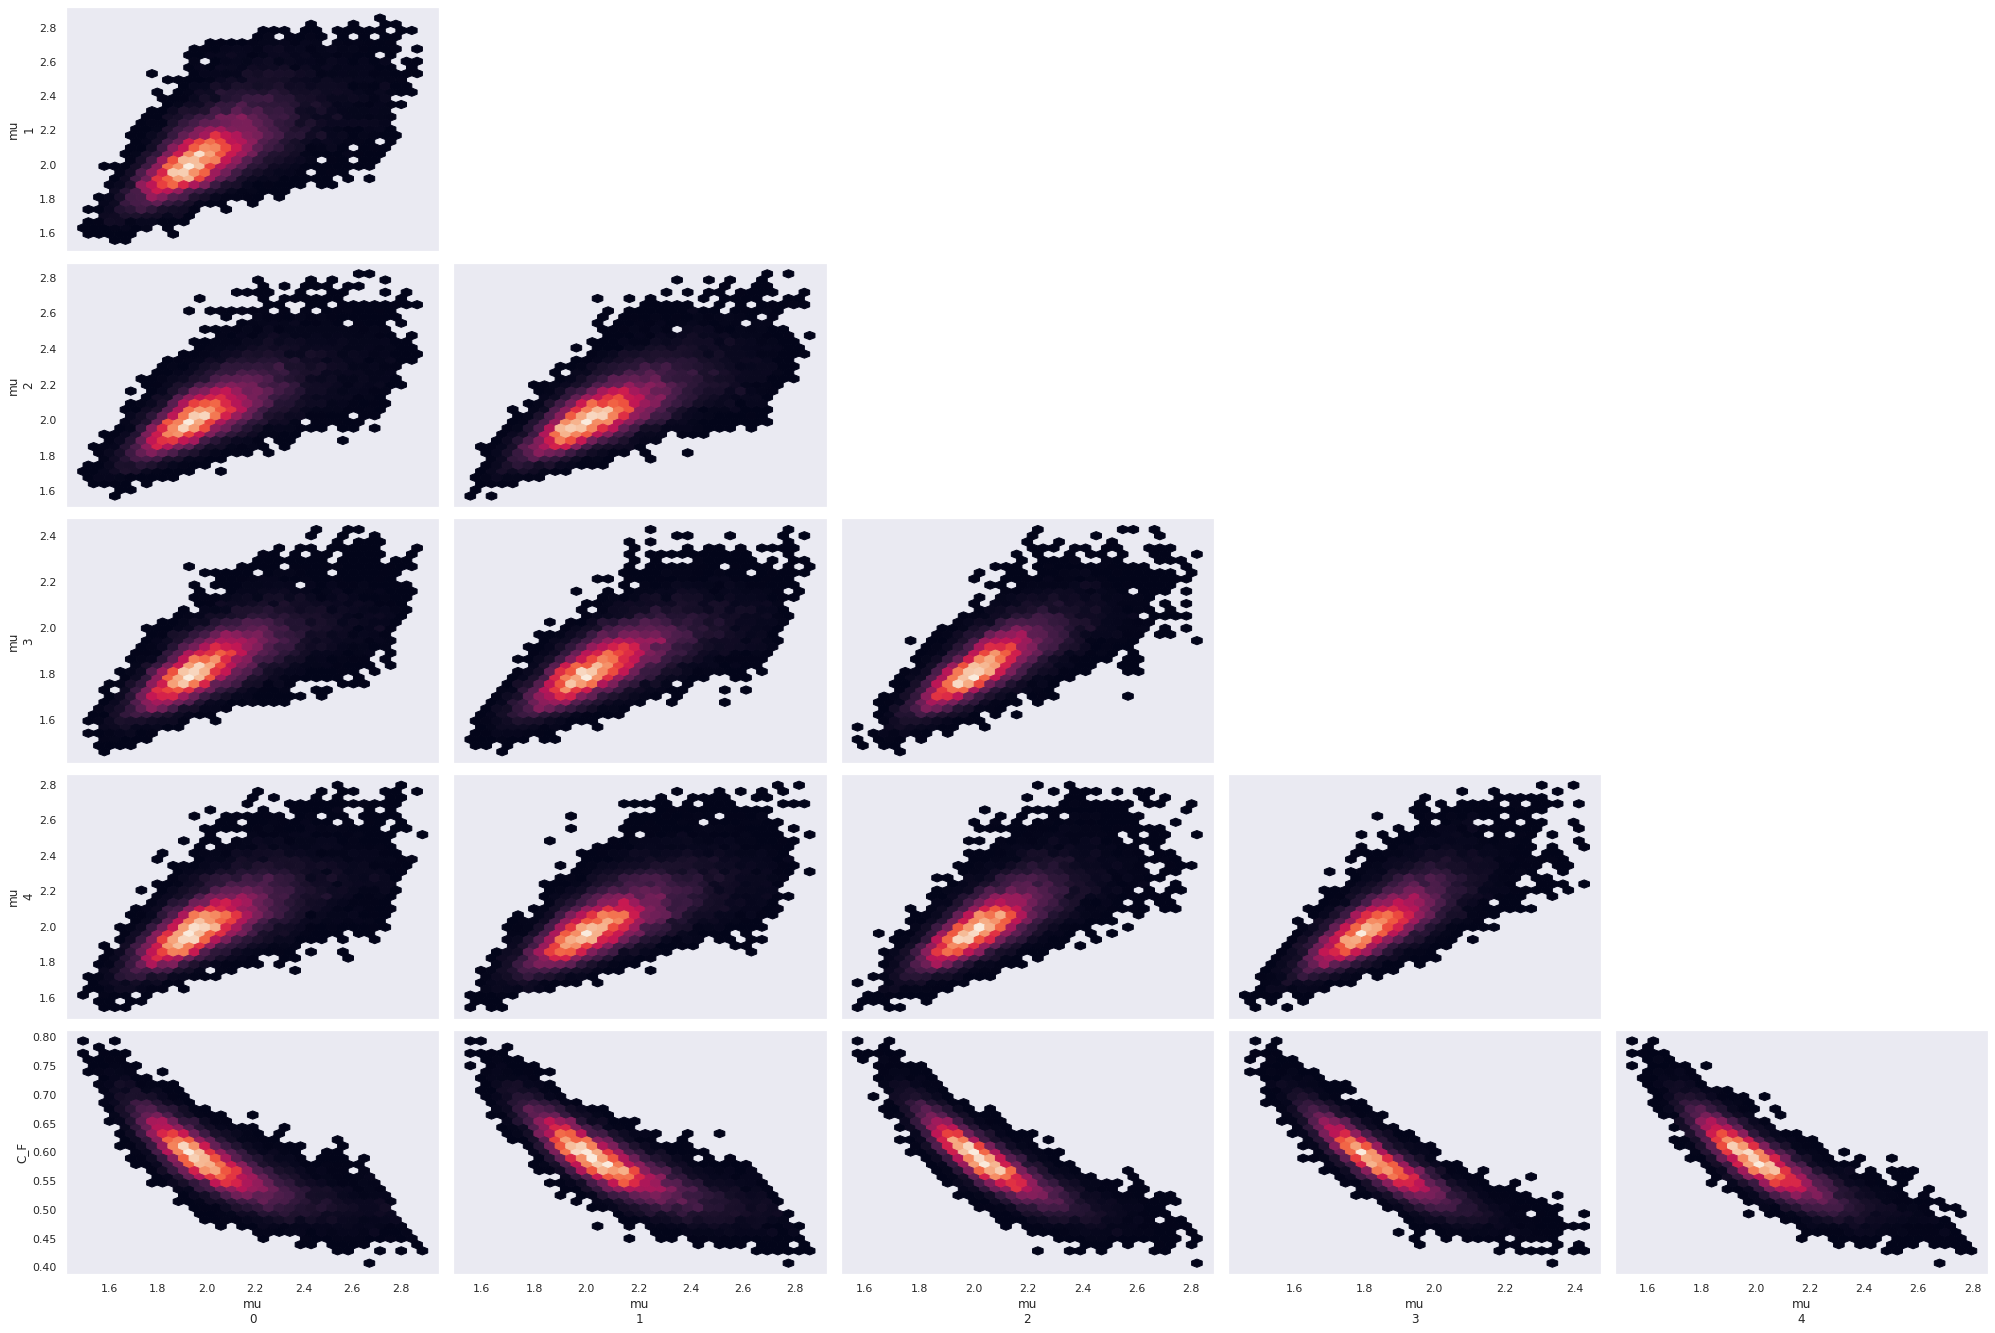

In [141]:
az.plot_pair(fit_classy_mu_phi, var_names=["mu", "C_F"], kind="hexbin")[-1]

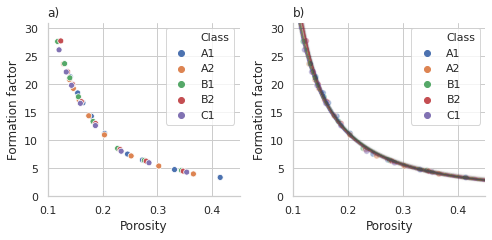

In [195]:
def posterior_examples(phi_predict, fit, class_number=1, num_examples=100):
    mu = fit['mu']
    phi_te = fit['phi_te']
    C_F = fit['C_F']
    samples = np.random.choice(len(mu), num_examples)
    for e in samples:
        yield C_F[e, class_number] * (phi_predict - phi_te[e, class_number]) ** -mu[e, class_number]

phi_pred = np.linspace(0.11, 0.45)
pal = sns.color_palette()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3.5))
for class_number in range(5):
    for y in posterior_examples(phi_pred, fit_classy_mu_phi, class_number, 100):
        ax2.plot(phi_pred, y, color=pal[class_number], alpha=.008)
#ax = plt.gca()
sns.scatterplot('phi', 'F', hue='Class', data=df, ax=ax2, alpha=.5)
sns.scatterplot('phi', 'F', hue='Class', data=df, ax=ax1)
ax_params = dict(
    xlabel='Porosity',
    xlim=(0.1, 0.45),
    ylabel='Formation factor',
    ylim=(0, 31)
)
ax1.set(**ax_params)
ax1.set_title('a)', loc='left')
ax2.set(**ax_params)
ax2.set_title('b)', loc='left')
sns.despine()
fig.tight_layout()
fig.savefig('bayes_figures/formation_factor_fit.png', dpi=300, bbox_inches='tight')

# No one likes models of intermediate complexity

In [158]:
model_code_classy_mu = """
data {
    int<lower=1> N;
    int<lower=1,upper=5> rock_class[N];
    vector[N] phi;
    vector[N] F;
}
parameters {
    real <lower=0, upper=0.118> phi_te; // Everything goes to hell if phi_te is greater than any value of phi
    real <lower=0, upper=100> C_F;
    real <lower=0> mu[5];
    real <lower=0> sigma_e;
}
transformed parameters {
    real mean_F[N];
    for (i in 1:N)
        mean_F[i] = C_F * (phi[i] - phi_te) ^ (-mu[rock_class[i]]);
}
model {
    F ~ normal(mean_F, sigma_e);
}
"""
model_classy_mu = pystan.StanModel(model_code=model_code_classy_mu)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_47942b4e3a54bdf4d8ff27acc8d0ab63 NOW.


In [159]:
data = {'N': len(df.phi), 'phi':df.phi, 'F':df.F, 'rock_class':df.Class.astype('category').cat.codes + 1}
fit_classy_mu = model_classy_mu.sampling(
    data=data, iter=6000, chains=4, warmup=1000, thin=1, seed=42, pars=['phi_te', 'C_F', 'mu', 'sigma_e']
)
fit_classy_mu

Inference for Stan model: anon_model_47942b4e3a54bdf4d8ff27acc8d0ab63.
4 chains, each with iter=6000; warmup=1000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
phi_te  3.9e-3  1.9e-4 3.2e-3 1.2e-4 1.4e-3 3.1e-3 5.7e-3   0.01    283   1.03
C_F        0.7  1.1e-3   0.03   0.65   0.68    0.7   0.71   0.75    584   1.02
mu[1]     1.73  2.0e-3   0.04   1.65    1.7   1.73   1.75   1.78    337   1.03
mu[2]      1.7  2.0e-3   0.04   1.62   1.68   1.71   1.73   1.76    324   1.03
mu[3]      1.7  2.0e-3   0.04   1.63   1.68   1.71   1.73   1.76    321   1.03
mu[4]     1.72  2.0e-3   0.04   1.64    1.7   1.73   1.75   1.78    329   1.03
mu[5]     1.69  1.9e-3   0.04   1.61   1.67    1.7   1.72   1.75    328   1.03
sigma_e   0.33  6.7e-4   0.04   0.26    0.3   0.32   0.35   0.42   3660    1.0
lp__     21.73    0.03   2.21  16.39  20.49  22.08  23.36  24.95   4538    1.0

Samples were drawn 

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f50cbd770a0>],
      dtype=object)

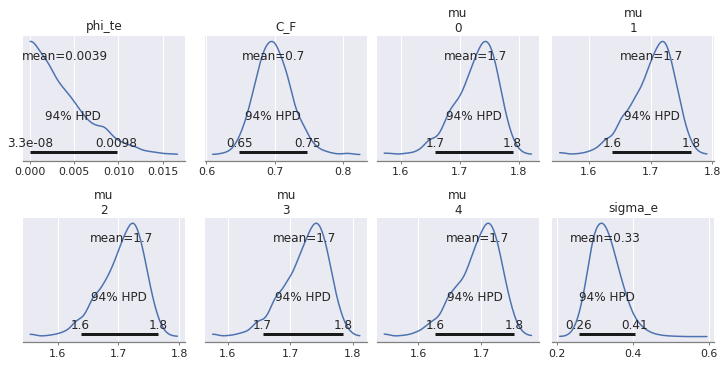

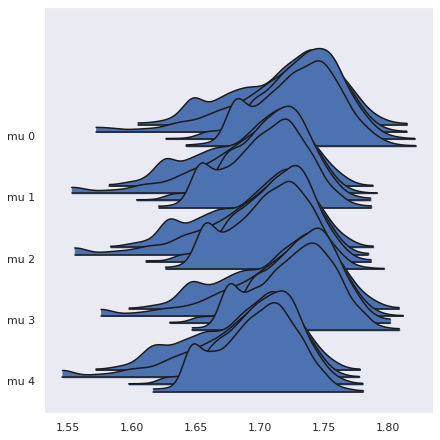

In [160]:
az.plot_posterior(fit_classy_mu, figsize=(10,5))
az.plot_forest(fit_classy_mu, var_names=['mu'], kind='ridgeplot')